# CNN - Project

## Student Identity

In [1]:
# @title #### Student Identity
student_id = "REA3X5EN"  # @param {type:"string"}
name = "Steven Adi Santoso"  # @param {type:"string"}
drive_link = "https://drive.google.com/drive/folders/1AEg6VQdzwqajBtovoR2G7liNo5OCaIZZ?usp=sharing"  # @param {type:"string"}

assignment_id = "00_cnn_project"

## Import Package

In [2]:
!pip install rggrader
from rggrader import submit, submit_image

## Project Description

In this CNN Project, you will create your own custom Image Classification. You can collect a dataset of images you are interested in and train a CNN model to differentiate between them. For example, a model could be trained to distinguish between different types of birds, cars, plants, or any other topic of interest.

In [3]:
#Write any package/module installation that you need here

!pip install transformers
!pip install scikit-learn
!pip install datasets
!pip install evaluate
!pip install accelerate
!pip install huggingface_hub

# Number
import numpy as np

# Huggingface library
from huggingface_hub import login

# Fine tuning
from datasets import load_dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    AutoFeatureExtractor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)
import evaluate  # Set metrics

import torch
from torchvision.transforms import (
    RandomResizedCrop,
    Compose,
    Normalize,
    ToTensor,
    Resize,
    CenterCrop,
    RandomHorizontalFlip
)

from PIL import Image

import requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.5 MB/s eta 0:00:00


In [4]:
# Login to huggingface
login()

## Task-1 Load the dataset

In this task, you will prepare and load your dataset. **You can choose any dataset you want**, make sure the data is diverse and large enough to prevent overfitting and improve the model's ability to generalize.

If you are using images from the internet, **please respect copyright and privacy laws**. Creative Commons licenses or public domain images are a safe bet, and many APIs (like the Unsplash API) provide access to a large number of such images.

### 1.1 Optional Custom Dataset
Provided below is a custom dataset template that you may want to use for your code. It's completely optional.

Alternatively, you can review the material on Data Augmentation or read the Pytorch tutorial https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In [ ]:
#an example of creating our own custom dataset, you can use this if you want/need. Completely optional.
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### 1.2 Write your code in the block below

In the code block below, prepare and load your dataset. Please include data preprocessing steps such as dividing the dataset into training, validation, and test sets, or data augmentation techniques that you used if any in this section. Do not put the code to build your model here.

Some techniques you may use:
- Find and load existing dataset from Huggingface or Kaggle. (Easy)
- Create your own custom dataset from the images you have in your possesion or internet search and load the dataset. (Hard)
- Etc.

Hint:
- Usually the dataset are loaded into train_dataset and test_dataset

In [5]:
# Write your data preprocessing code here

# The datasets have 20 class of food
train_dataset = load_dataset("Matthijs/snacks", split="train")
val_dataset = load_dataset("Matthijs/snacks", split="validation")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/952 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

In [6]:
# Create the label2id and id2label
labels = train_dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [7]:
# Create and apply the processor
# Get the image processor
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Get the value
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

# Create the transform
_train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

_val_transforms = Compose([
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std),
])

# Create the transform function
def train_transforms(datasets):
  datasets["pixel_values"] = [
      _train_transforms(image.convert("RGB")) for image in datasets["image"]
      ]
  del datasets["image"]
  return datasets

def val_transforms(datasets):
  datasets["pixel_values"] = [
      _val_transforms(image.convert("RGB")) for image in datasets["image"]
      ]
  del datasets["image"]
  return datasets

# Applying the transform to the dataset
train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

### 1.3 Submission

You'll submit the link to your dataset for Task-1.

- If you use existing dataset from Kaggle or Huggingface, then you can put the link to those dataset here.

- If you use your own custom dataset, Upload and store the custom dataset in your Google Drive that you shared with us and put the link to the folder containing that dataset here.

In [8]:
# Submit Method
dataset_link = "https://huggingface.co/datasets/Matthijs/snacks" # Put your model link

question_id = "00_cnn_project_dataset"
submit(student_id, name, assignment_id, dataset_link, question_id, drive_link)

'Assignment successfully submitted'

## Task-2 Build your model

In this task, you will now build and save your model. You can either create your own CNN model or choose any pretrained model that you feel is most appropriate for your dataset.

### 2.1 Write your code in the block below

In the code block below, write the code to **create your model, either from scratch or fine tuning a pretrained model**. You will need to write the code for your model definition, such as the layers used, loss function and optimizer. Please include also the training and validation loops.

Make sure you **save your model to a file** and **measure the accuracy of your model**, as this will be submitted for this task.

Some techniques you may use:
- Use pretrained model. (Easy)
- Create a CNN model from scratch. (Hard)
- Etc.

Hint:
- Use GPU in Google Colab, it significantly improves the time taken for training, compared to CPU.
- **Google Colab GPU usage for free-tier have a limit**, which is unknown, so I suggest you try out in CPU mode that your code works without error, then use GPU for traininig.
- If you are going to upload to Huggingface by using the Transformer Trainer during training, make sure you use the Huggingface method. Refer to Transfer Learning section or read the documentation here: https://huggingface.co/docs/transformers/model_sharing

In [9]:
#Write your code to build your model here

# Load the base model
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(id2label),
    label2id=label2id,
    id2label=id2label,
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Creating the metrics
metrics = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return metrics.compute(predictions=predictions, references=labels)

In [11]:
# Set the training args
training_args = TrainingArguments(
    output_dir="model/vit-snack-classification-fp16",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=0.00005,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    logging_steps=100,
    eval_steps=100,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [12]:
# Set the training trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DefaultDataCollator(),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

In [13]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,2.599200,2.113494,0.856545
200,1.799900,1.392617,0.913089
300,1.279600,1.032017,0.929843
400,0.953400,0.807557,0.930890
500,0.798700,0.679467,0.943455
600,0.709300,0.594471,0.945550
700,0.641700,0.535953,0.957068
800,0.544200,0.503943,0.954974
900,0.524600,0.484031,0.956021


TrainOutput(global_step=909, training_loss=1.0885982088523336, metrics={'train_runtime': 282.1662, 'train_samples_per_second': 51.438, 'train_steps_per_second': 3.222, 'total_flos': 1.1249001862354207e+18, 'train_loss': 1.0885982088523336, 'epoch': 3.0})

In [14]:
# Evaluate
accuracy = trainer.evaluate(eval_dataset=val_dataset)
accuracy = accuracy['eval_accuracy']

print(accuracy)

0.9434554973821989


### 2.2 Submission

You'll submit the link to your model and the accuracy score for your model in this section.

Remember to download or move/upload your model from Google Colab to your Google Drive. Put the link to the Google Drive for your model below.

If you use a different variable to store your accuracy, remember to also change the `accuracy` variable below.

In [15]:
# Submit Method
model_link = "https://drive.google.com/drive/folders/1lFsi-UVb9ryJRgLRTXhh6VsWSlG-zt2D?usp=sharing" # Put your model link

question_id = "01_cnn_project_model_link"
submit(student_id, name, assignment_id, model_link, question_id, drive_link)
question_id = "02_cnn_project_model_accuracy"
submit(student_id, name, assignment_id, str(accuracy), question_id, drive_link)

'Assignment successfully submitted'

## Task-3 Model Inference

In this task, you will be exercising the application of your model, or as it's commonly referred to in AI terminology, you will be performing inference using your model.

Simply load your saved model from Task-2 and create an inference for the model. Where you'll feed an image as input and the model will output the label as well as the percentage of confidence for the label.

### 3.1 Write your code in the block below

In the code block below write the code to use the model you created in Task-2. Load the model and input image, afterwards, show the result of the label/class together with confidence level in percentage as well as the input image.

In [16]:
# Write your code for inference here

# Load the model
snack_model = AutoModelForImageClassification.from_pretrained(
    "silvering/vit-snack-classification-fp16",
)

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Predicted class: banana (Confidence: 85.45)


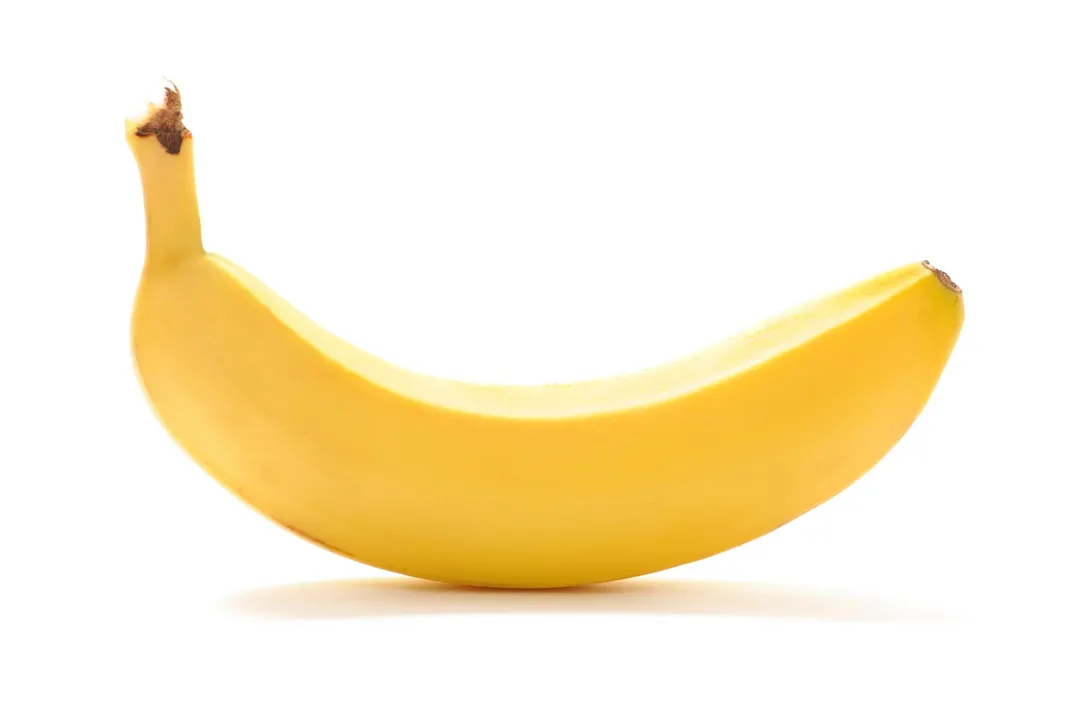

In [17]:
# Inference
url_image = "https://th-thumbnailer.cdn-si-edu.com/6RD8JDrASGTSjdbsJkg-37OY9mQ=/1072x720/filters:no_upscale()/https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer/d5/24/d5243019-e0fc-4b3c-8cdb-48e22f38bff2/istock-183380744.jpg"  # @param {type:"string"}

# Processing
im = Image.open(requests.get(url_image, stream=True).raw).convert("RGB")

inputs = processor(im, return_tensors='pt')
output = snack_model(**inputs)

probs = output.logits.softmax(1)
ind = int(probs.argmax(1))

print(f"Predicted class: {id2label[str(ind)]} (Confidence: {round(float(probs[0][probs.argmax(1)]) * 100, 2)})")
im

### 3.2 Submission

You'll submit a screenshot of your inference in this section. Remember to save the screenshot first before submitting it.

Hint:

![Upload colab](https://storage.googleapis.com/rg-ai-bootcamp/project-3-pipeline-and-gradio/upload-colab.png)

- In Google Colab you can just use the "Folder" sidebar and click the upload button. Make sure your screenshot match below requirements:

    - Image name screenshot is `submission.jpg`. If you change the name of the screenshot  file, change it also in the submit_image parameter.
    - The input image and label as well as percentage of confidence should be included in the screenshot

Here is an example of a correct screenshot:

![Screenshot submission sammple - hummer](https://storage.googleapis.com/rg-ai-bootcamp/projects/project-5-cnn-hummer.png)

In [18]:
# Submit Method

question_id = "03_cnn_project_inference"
submit_image(student_id, question_id, './submission.png')

'Assignment successfully submitted'

## Task-4 Model Publishing

In this task, you will push your model to Huggingface. Once you've pushed your model to the Hugging Face Model Hub, you'll have a link that points directly to your model's page. You can share this link with others, and they can use it to directly load your model for their own uses.

### 4.1 Write your code in the block below

In the code block below, write the code to push your model to Huggingface. There are several methods to do this, please refer to the documentation: https://huggingface.co/docs/transformers/model_sharing

Some techniques you may use:
- If you use the Transformer Trainer during the training loop when you create your model above, then you can simply put your `trainer.push_to_hub()` here.
- You can also use the web interface on Huggingface.

Hint:
- Remember to login first to your Huggingface account.
- If you are pushing programmaticaly, then use the huggingface-cli to login.

In [19]:
#Write your code for publishing here

trainer.push_to_hub()

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1708676714.27ac23a14ff2.698.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

events.out.tfevents.1708676426.27ac23a14ff2.698.0:   0%|          | 0.00/9.80k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/silvering/vit-snack-classification-fp16/commit/417531f782fc0e8aabcd78dfa2d0232f3f09e61c', commit_message='End of training', commit_description='', oid='417531f782fc0e8aabcd78dfa2d0232f3f09e61c', pr_url=None, pr_revision=None, pr_num=None)

### 4.2 Submission

You'll submit a a link to your huggingface model in this section.

The following link is an example of what a trained model's page looks like: https://huggingface.co/aditira/emotion_classification. This is not your model, but rather an example of what your final result might resemble.

Remember, for this project you should push your output model to your own Hugging Face account. The link for your model will be different and should reflect your own username and model name.

In [20]:
# Submit Method
huggingface_model_link = "https://huggingface.co/silvering/vit-snack-classification-fp16" # Put your model link

question_id = "04_cnn_project_publish"
submit(student_id, name, assignment_id, huggingface_model_link, question_id, drive_link)

'Assignment successfully submitted'

FIN